In [5]:
import sourmash
import csv

In [2]:
ls

README.md       zymomock/       zymomock.ipynb  zymomock.zip


In [3]:
ls zymomock

SRR12324253.abundtrim.sig  zymomock-queries.zip
zymomock-nbhds.zip


In [40]:
!sourmash gather ./zymomock/SRR12324253.abundtrim.sig ./zymomock/zymomock-queries.zip -o queries.x.zymomock.csv --ignore-abundance


== This is sourmash version 4.2.4.dev0+g73aeb155.d20220116. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

selecting default query k=31.
loaded query: SRR12324253... (k=31, DNA)
loaded 1 databases.                                                            

Starting prefetch sweep across databases.
Found 18 signatures via prefetch; now doing gather.

overlap     p_query p_match
---------   ------- -------
15.8 Mbp      10.9%   62.7%    SSXJ01000001.1 Cryptococcus neoforman...
11.3 Mbp       7.8%   97.6%    WMJW01000001.1 Saccharomyces cerevisi...
7.4 Mbp        5.1%   67.7%    JSPL01000060.1 Escherichia coli strai...
4.7 Mbp        3.2%   98.4%    VFAF01000002.1 Salmonella enterica st...
4.0 Mbp        2.7%   99.8%    CP039755.1 Bacillus subtilis strain N...
5.2 Mbp        2.2%   43.3%    FREP01002036.1 Escherichia coli isola...
2.8 Mbp        1.9%  100.0%    CP039751.1 Listeria monocytogenes str...
2.7 Mbp        1.9%   99.8%    VFAE01000004.1 Staphylococcus 

In [50]:
!sourmash gather ./zymomock/SRR12324253.abundtrim.sig ./zymomock/zymomock-nbhds.zip -o nbhds.x.zymomock.csv --ignore-abundance


== This is sourmash version 4.2.4.dev0+g73aeb155.d20220116. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

selecting default query k=31.
loaded query: SRR12324253... (k=31, DNA)
loaded 1 databases.                                                            

Starting prefetch sweep across databases.
Found 18 signatures via prefetch; now doing gather.

overlap     p_query p_match
---------   ------- -------
20.3 Mbp      14.0%  100.0%    nbhd:JSPL01000060.1 Escherichia coli ...
19.5 Mbp      13.4%  100.0%    nbhd:SSXJ01000001.1 Cryptococcus neof...
12.7 Mbp       8.7%   99.9%    nbhd:WMJW01000001.1 Saccharomyces cer...
12.8 Mbp       8.4%   96.0%    nbhd:VFAF01000002.1 Salmonella enteri...
13.7 Mbp       4.6%   49.0%    nbhd:FREP01002036.1 Escherichia coli ...
4.7 Mbp        3.2%   99.4%    nbhd:CP039755.1 Bacillus subtilis str...
3.8 Mbp        2.6%   99.3%    nbhd:VFAE01000004.1 Staphylococcus au...
3.6 Mbp        2.5%   99.4%    nbhd:CP039750.1 Limosilactobac

In [41]:
def get_ident(name):
    "pick off identifier, stripping off nbhd: prefix if present."
    name = name.split(' ')[0]
    if name.startswith('nbhd:'):
        name = name[5:]
    return name

In [108]:
gather1 = []
with open('queries.x.zymomock.csv', newline="") as fp:
    r = csv.DictReader(fp)
    gather1.extend(r)

full_idents = {}

gather1_d = {}
gather1_keys = []
for row in gather1:
    ident = get_ident(row['name'])
    full_idents[ident] = " ".join(row['name'].split(' ')[:3])
    gather1_d[ident] = row
    gather1_keys.append(ident)

In [51]:
gather2 = []
with open('nbhds.x.zymomock.csv', newline="") as fp:
    r = csv.DictReader(fp)
    gather2.extend(r)
    

gather2_d = {}
gather2_keys = []
for row in gather2:
    ident = get_ident(row['name'])
    gather2_d[ident] = row
    gather2_keys.append(ident)

In [43]:
metag = sourmash.load_one_signature('zymomock/SRR12324253.abundtrim.sig', ksize=31)

In [44]:
queries = list(sourmash.load_file_as_signatures('zymomock/zymomock-queries.zip'))
queries_d = {}
for ss in queries:
    ident = get_ident(ss.name)
    queries_d[ident] = ss

In [45]:
nbhds = list(sourmash.load_file_as_signatures('zymomock/zymomock-nbhds.zip'))
nbhds_d = {}
for ss in nbhds:
    ident = get_ident(ss.name)
    nbhds_d[ident] = ss

In [59]:
remaining_hashes = set(metag.minhash.hashes)
unique_hashes_1x = []
for ident in gather1_keys:
    row = gather1_d[ident]
    match = queries_d[ident]
    match_hashes = set(match.minhash.hashes)
    unique_overlap = remaining_hashes & match_hashes
    #print(ident, len(remaining_hashes), len(unique_overlap), row['unique_intersect_bp'], row['remaining_bp'])
    remaining_hashes -= unique_overlap
    unique_hashes_1x.append((ident, unique_overlap))


In [60]:
remaining_hashes = set(metag.minhash.hashes)
unique_hashes_2x = []
for ident in gather2_keys:
    row = gather2_d[ident]
    match = nbhds_d[ident]
    match_hashes = set(match.minhash.hashes)
    unique_overlap = remaining_hashes & match_hashes
    #print(ident, len(remaining_hashes), len(unique_overlap), row['unique_intersect_bp'], row['remaining_bp'])
    remaining_hashes -= unique_overlap
    unique_hashes_2x.append((ident, unique_overlap))


In [61]:
for (nbhd_ident, nbhd_match) in unique_hashes_2x:
    total = 0
    for (query_ident, query_match) in unique_hashes_1x:
        overlap = query_match & nbhd_match
        
        if overlap:
            print(f"{nbhd_ident} <= {query_ident} - {len(overlap)}")
            total += len(overlap)
    print('xxx', nbhd_ident, len(nbhd_match), total)
    print('---')

JSPL01000060.1 <= WMJW01000001.1 - 1
JSPL01000060.1 <= JSPL01000060.1 - 7395
JSPL01000060.1 <= VFAF01000002.1 - 58
JSPL01000060.1 <= CP039755.1 - 2
JSPL01000060.1 <= FREP01002036.1 - 540
JSPL01000060.1 <= CP041013.1 - 462
JSPL01000060.1 <= VFAG01000002.1 - 200
xxx JSPL01000060.1 20341 8658
---
SSXJ01000001.1 <= SSXJ01000001.1 - 15566
SSXJ01000001.1 <= AE017341.1 - 1420
SSXJ01000001.1 <= CP003820.1 - 1271
xxx SSXJ01000001.1 19471 18257
---
WMJW01000001.1 <= WMJW01000001.1 - 11025
WMJW01000001.1 <= LOQK01000001.1 - 317
WMJW01000001.1 <= CM010209.1 - 153
WMJW01000001.1 <= CM006175.1 - 64
xxx WMJW01000001.1 12686 11559
---
VFAF01000002.1 <= VFAF01000002.1 - 4562
VFAF01000002.1 <= CP039755.1 - 1
VFAF01000002.1 <= FREP01002036.1 - 1
VFAF01000002.1 <= VFAG01000002.1 - 1
xxx VFAF01000002.1 12274 4565
---
FREP01002036.1 <= CP039755.1 - 3
FREP01002036.1 <= FREP01002036.1 - 2656
FREP01002036.1 <= CP039751.1 - 8
FREP01002036.1 <= CP039752.1 - 384
FREP01002036.1 <= VFAG01000002.1 - 80
xxx FREP01002

In [62]:
import plotly.graph_objects as go

In [113]:
def make_fig():
    #labels = obj.make_labels()
    #src_l, dest_l, cnt_l, color_l, label_l = obj.make_lists()
    labels = []
    src_l = []
    dest_l = []
    cnt_l = []
    color_l = []
    label_l = []
    
    source_idx = {}
    for n, (query_ident, _) in enumerate(unique_hashes_1x):
        source_idx[query_ident] = n
        labels.append(full_idents[query_ident])
    dest_idx = {}
    source_idx["unassigned"] = len(unique_hashes_1x)
    labels.append("unassigned")
    base = len(unique_hashes_1x) + 1
    for n, (nbhd_ident, _) in enumerate(unique_hashes_2x):
        dest_idx[nbhd_ident] = base + n
        labels.append(full_idents[nbhd_ident])
        
    #source_idx["unassigned"] = base + n + 1
    
    # iterate over all sinks, account for all sources
    num = 0
    leftovers = []
    for (nbhd_ident, nbhd_match) in unique_hashes_2x:
        total = 0
        for (query_ident, query_match) in unique_hashes_1x:
            overlap = query_match & nbhd_match
        
            if overlap:
                print(f"{nbhd_ident} <= {query_ident} - {len(overlap)}")
                total += len(overlap)
                from_idx = source_idx[query_ident]
                to_idx = dest_idx[nbhd_ident]
                
                src_l.append(from_idx)
                dest_l.append(to_idx)
                cnt_l.append(len(overlap))
                if query_ident == nbhd_ident:
                    color_l.append("lightseagreen")
                else:
                    color_l.append("palevioletred")
                label_l.append("")
    
        print('xxx', nbhd_ident, len(nbhd_match), total)
        leftover = len(nbhd_match) - total
        
        if leftover:
            leftovers.append((nbhd_ident, leftover))

        print('---')
        #break
        num += 1
        if num == 3:
            break
            
    if leftovers:
        for nbhd_ident, leftover in leftovers:
            from_idx = source_idx["unassigned"]
            to_idx = dest_idx[nbhd_ident]

            src_l.append(from_idx)
            dest_l.append(to_idx)
            cnt_l.append(leftover)
            color_l.append("grey")
            label_l.append("")
            print('XYZ', from_idx, to_idx)
        

    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(color = "black", width = 0.5),
          label = labels,
          color = "blue"
        ),
        link = dict(
          source = src_l,
          target = dest_l,
          value = cnt_l,
          color = color_l,
          label = label_l,
      ))])
    
    return fig

fig = make_fig()


JSPL01000060.1 <= WMJW01000001.1 - 1
JSPL01000060.1 <= JSPL01000060.1 - 7395
JSPL01000060.1 <= VFAF01000002.1 - 58
JSPL01000060.1 <= CP039755.1 - 2
JSPL01000060.1 <= FREP01002036.1 - 540
JSPL01000060.1 <= CP041013.1 - 462
JSPL01000060.1 <= VFAG01000002.1 - 200
xxx JSPL01000060.1 20341 8658
---
SSXJ01000001.1 <= SSXJ01000001.1 - 15566
SSXJ01000001.1 <= AE017341.1 - 1420
SSXJ01000001.1 <= CP003820.1 - 1271
xxx SSXJ01000001.1 19471 18257
---
WMJW01000001.1 <= WMJW01000001.1 - 11025
WMJW01000001.1 <= LOQK01000001.1 - 317
WMJW01000001.1 <= CM010209.1 - 153
WMJW01000001.1 <= CM006175.1 - 64
xxx WMJW01000001.1 12686 11559
---
XYZ 18 19
XYZ 18 20
XYZ 18 21


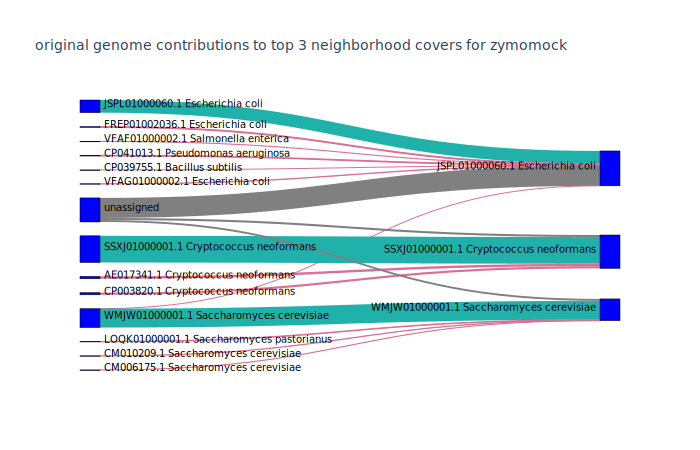

In [118]:
fig.update_layout(title_text="original genome contributions to top 3 neighborhood covers for zymomock", font_size=10)
fig.show("svg")